# 변수 선택
[파이썬 기반의 AI를 위한 기초수학, 확률 및 통계]의 20장 내용

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import statsmodels.formula.api as smf
import statsmodels.api as sm

from warnings import filterwarnings
filterwarnings('ignore')

plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 사용할 데이터셋 : 보스턴 주의 각 지역의 주택중위가격 예측
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
df = pd.read_csv(url, sep='\s+', header=None)
df.columns = ['CRIM','ZN','INDUS','CHAS','NOX',
              'RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df.columns = df.columns.str.lower()

df.shape

(506, 14)

- CRIM
    - per capita crime rate by town
    - 도시별 1인당 범죄율
- ZN
    - proportion of residential land zoned for lots over 25,000 sq.ft.
    - 25,000 sq.ft 이상의 로트용 구역토지 비율
- INDUS
    - proportion of non-retail business acres per town
    - 도시별 비 소매 사업 땅의 비율
- CHAS
    - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    - Charles River 경계여부
- NOX
    - nitric oxides concentration parts per 10 million
    - 천만당 산화질소 농도
- RM
    - average number of rooms per dwelling
    - 주거당 평균 방수
- AGE
    - proportion of owner-occupied units built prior to 1940
    - 1940년 이전에 건설된 소유주 차지 비율
- DIS
    - weighted distances to five Boston employment centres
    - 보스턴 고용 센터 5곳까지의 가중치 거리
- RAD
    - index ol accessibility to radial highways
    - 방사형 고속도로 접근성 지수
- TAX
    - full-value property-tax rate per $10,000
    - $10,000 당 완전 가치 재산세율
- PTRATIO
    - pupil-teacher ratio by town
    - 도시별 학생 - 교사 비율
- B
    - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    - 100(도시별 흑인 비율-0.63)^2
- LSTAT
    - % lower status of the population
    - 인구 감소 % 상태
- MEDV
    - lr/edian value of owner-occupied homes in $1000's
    - 1000달러 단위 주택 소유 주택의 중간 값

## 20.2 모형의 선택과 기준
모형의 적합도(goodness of fit)가 비슷하다면 가급적 변수의 수를 줄이는 것이 용이하다. 주요 이유로는 차원의 저주를 피할 수 있고, 해석하기가 용이하며, 모델적합 시간을 줄일 수 있다는 것이다. 또한 종속변수를 설명하는데 있어 redundant하거나 irrelevant한 변수를 제거함으로써 noise까지 모형화하는 과적합을 피하고자 하는 것이다.

모형이 적합하다 것은 현재의 데이터에만 잘 맞도록 하는 것을 넘어 미래의 데이터가 주어졌을 때에도 잘 예측하는 것, 즉 모형의 일반화 성능(generalization performance)을 갖는 것 역시 중요하다. 일반화 성능을 위해서는 모형을 적합시키는 데이터(train data)와 검증하는 데이터(validation data)가 분리되어 있어야 한다.

즉 변수의 일부를 선택한다는 것은 여러가지 모형을 만들어내는 것이며 이 중 가장 적합한 모형을 선택하기 위해서는 데이터 분리를 통해 모형들을 검증해야 한다.

우선 산점도 행렬을 통해 어떤 변수들이 유의한지 일차적으로 살펴볼 수 있다.

<Figure size 600x600 with 0 Axes>

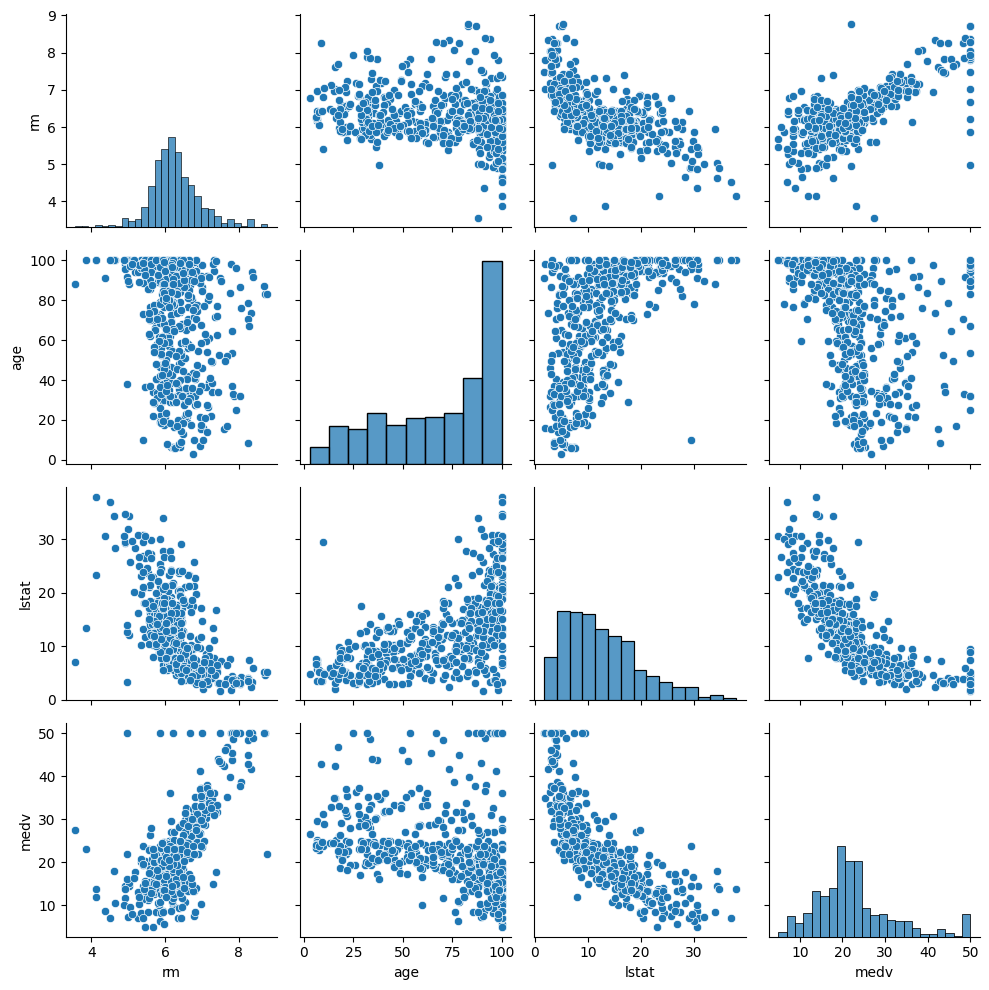

In [ ]:
# 산점도 행렬
import seaborn as sns

plt.figure(figsize=(6,6))
sns.pairplot(df[['rm','age','lstat','medv']])
plt.tight_layout()

변수간 상관관계를 확인하는 과정 역시 거칠 수 있다.

,crim,zn,indus
crim,1.000000,-0.200469,0.406583
zn,-0.200469,1.000000,-0.533828
indus,0.406583,-0.533828,1.000000


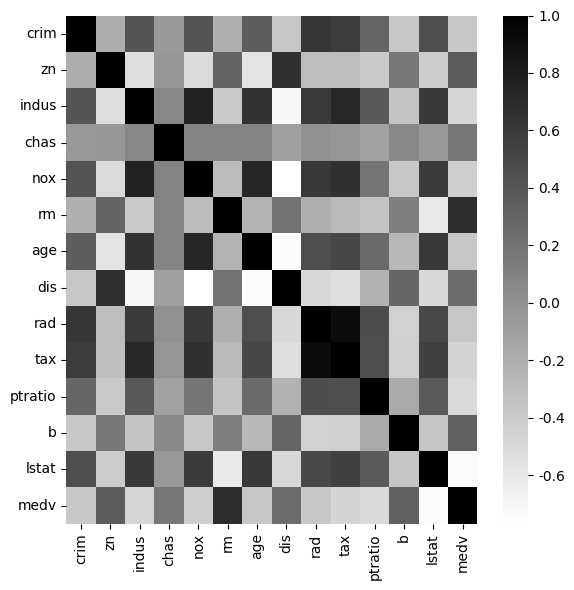

In [ ]:
# 상관계수 구하기
display(df.corr().iloc[:3,:3])

plt.figure(figsize=(6,6))
sns.heatmap(df.corr(),cmap='binary')
plt.tight_layout()

상관계수를 통해 일차적으로 의미가 있다고 생각하는 변수들(ex) $\rho > 0.5$)은 indus, rm, tax, pratio, lstat이며 가장 의미가 없다고 생각되는 변수는 chas, dis이다.

이때 모든 변수를 다 넣은 모델과 유의미하지 않은 변수를 빼고 적합시킨 모델을 비교해 보도록 한다.

### 20.2.1 분산분석 기법에 의한 모델 비교
$SSE = Σ_{i=1}^n(Y_i - \hat{Y}_i)^2$

<img src="https://lh3.google.com/u/0/d/1PKRalXaVYAl1h3L3UzO0a4eXsd1DE68q=w1227-h883-iv1" class="a-b-ta-Ua" alt="캡쳐23.png 표시 중" aria-hidden="true">

$d$ : 2개의 모델 간 적합된 모수의 개수 차이<br>
$k$ : 전체 변수의 개수<br>
$SSE(full)$ : 모든 변수를 넣었을 경우 설명되지 않은 잔차의 변동<br>
$SSE(reduced)$ : 유의미한 변수만 넣은 경우 설명되지 않은 잔차의 변동 <br>

$SSE(full)\over \sigma^2$ ~ $\chi^2(n-k-1)$<br>
$SSE(reduced) \over \sigma^2$~$\chi^2(n-(k-d)-1)$<br>
--> $SSE(reduced)-SSE(full)$ ~ $ \chi^2(d)$

<img src="https://lh3.google.com/u/0/d/1xDN_cqnVoHk2EXCwN0gila0EIHllHz3K=w1920-h883-iv1" class="a-b-ta-Ua" alt="캡쳐22.png 표시 중" aria-hidden="true">

F분포의 정의에 따라 각각의 자유도로 나눈 두 카이제곱 분포의 비는 F분포가 된다.(자유도 2개는 분자와 분모에 쓰인 카이제곱들의 자유도)

만약 분자의 값이 크다면 축소 모형의 잔차제곱합(에러)이 크다는 것이므로 유의미한 변수가 빠졌다는 것을 의미한다. 즉, 2개 모델 간 유의미한 차이가 있다고 할 수 있다.


In [ ]:
# 축소모델: tax를 제외하고 적합시킴
xvars = ['indus','rm','tax','ptratio','lstat','chas','dis']
fmla = 'medv~' + '+'.join(xvars)
reduced_fmla = 'medv~' + '+'.join(list(set(xvars) - {'tax'}))

# full_model
full_model = smf.ols(fmla, data=df).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     169.8
Date:                Thu, 10 Aug 2023   Prob (F-statistic):          1.55e-127
Time:                        01:06:42   Log-Likelihood:                -1531.6
No. Observations:                 506   AIC:                             3079.
Df Residuals:                     498   BIC:                             3113.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.6898      4.100      6.023      0.0

In [ ]:
# 축소 모델 적합
reduced_model = smf.ols(reduced_fmla, data=df).fit()
print('축소모델의 r-square: ',reduced_model.rsquared)
print(sm.stats.anova_lm(reduced_model, full_model))

축소모델의 r-square:  0.703227407853279
   df_resid           ssr  df_diff   ss_diff         F    Pr(>F)
0     499.0  12677.025717      0.0       NaN       NaN       NaN
1     498.0  12613.667328      1.0  63.35839  2.501452  0.114376


눈여겨본 변수를 모두 포함한 모델은 $R^2$=0.705, tax를 제거한 모델은 $R^2$ = 0.703으로 아주 작게 감소하였다. 실제로 유의한 영향을 미친 것인지 SSE를 통해 비교해보니 F 통계량이 유의하지 않았다. (p_value : 0.1144) 즉, 유의수준 5%에서는 해당 변수를 입력변수로 하지 않아도 큰 문제가 없다.

## 교차 검증
잘 적합된 모델이라는 것은 주어진 표본만을 잘 적합시키는 것을 의미하지 않는다. 즉, 모집단 전체를 잘 적합시키는 모형이 필요한 것인데 이를 일반화 성능이라고 한다. 이를 위해 모델에 적합시키는 train data와 일반화 성능을 검증하는 validation data를 나누도록 한다.

검증데이터에서 모델 적합도가 좋은지 MSE, RSS등을 통해 확인할 수 있으며 이와 같이 검증데이터를 통해 모형을 선택하는 것을 교차검증(cross-validation)에 의한 모형 선택이라고 한다.

$RSS(SSE) = \epsilon_1^2 + \epsilon_2^2 + \cdots + \epsilon_n^2$

교차검증에는 표본 데이터를 2개로만 나누어 검증하는 단순 교차검증(simple cross validation)이 있고, 일반적으로는 K개로 데이터를 나누어 검증하는 K-겹 교차검증(K-fold cross validation)을 사용한다.

우선 단순 교차검증을 살펴보도록 한다.



In [ ]:
# 데이터 분할
# 훈련 데이터
np.random.seed(123)
idx = np.random.choice(np.arange(len(df)), size=int(len(df)*0.7), replace=False)
train = df.iloc[idx]
train.shape

(354, 14)

In [ ]:
# 검증 데이터
non_idx = list(set(np.arange(len(df)))-set(idx))
valid = df.iloc[non_idx]
valid.shape

(152, 14)

In [ ]:
# 입력 변수 구성
xvars = list(set(df.columns) - {'medv'})
xvars.sort()

# 각 변수를 하나씩 적합하기
rss = []
for j in np.arange(len(xvars)):
    varname = xvars[j]
    fit = smf.ols('medv~'+ varname, data=train).fit()
    pred = fit.predict(sm.add_constant(valid[varname]))
    tmp_rss = np.sum((valid['medv'].values - pred)**2)
    rss.append(tmp_rss)

# 최소값을 주는 변수
xvars[np.nanargmin(rss)]

'rm'

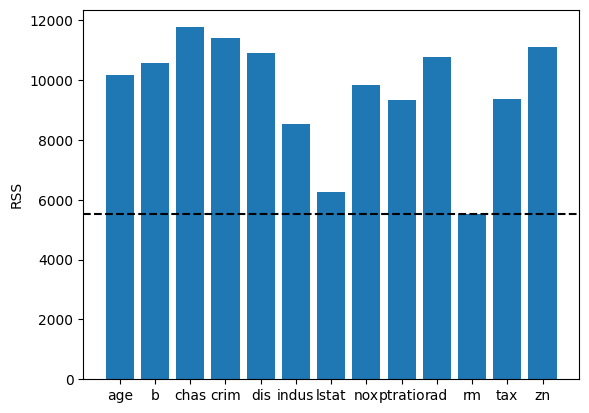

In [ ]:
plt.bar(xvars,rss)
plt.axhline(min(rss), linestyle='--',color='k')
plt.ylabel('RSS')
plt.show()

rm이 validation data에서 가장 작은 RSS를 보이는 것을 확인했다.

K fold cross validation의 과정은 다음과 같다.

In [ ]:
from sklearn.model_selection import KFold

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=123)
X = df[xvars]
y = df['medv']

## 결과 배열 정리
mm = np.zeros(shape=(num_folds, len(xvars)))

# 각 fold에 대하여
for i, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    # 각 변수에 대해
    for j in np.arange(len(xvars)):
        varname = xvars[j]
        fit = smf.ols('medv~'+ varname, data=pd.concat([X_train, y_train], axis=1)).fit()
        pred = fit.predict(sm.add_constant(X_valid[varname]))
        tmp_rss = np.sum((y_valid - pred)**2)
        mm[i,j] = tmp_rss

# 각 변수별로 잔차 제곱합 평균 구하기
rss_mean = np.mean(mm, axis=0)
rss_mean.round(3)


array([7346.338, 7616.267, 8350.58 , 7449.084, 8030.554, 6566.661,
       3918.69 , 7003.566, 6391.593, 7342.039, 4438.803, 6707.85 ,
       7498.508])

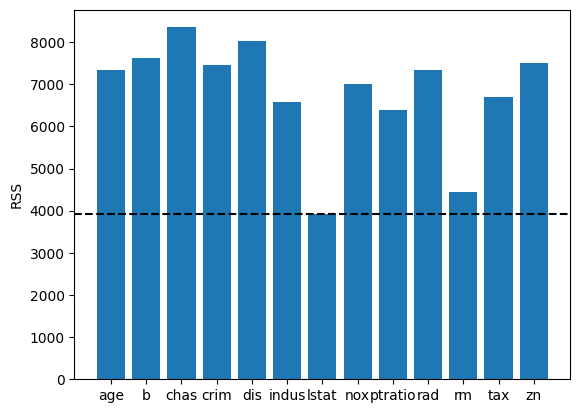

In [ ]:
plt.bar(xvars,rss_mean)
plt.axhline(min(rss_mean), linestyle='--',color='k')
plt.ylabel('RSS')
plt.show()

단순 교차 검증의 결과와는 상이하게 lstat 변수가 선정되었다.

## 20.4 단계적 모형 선택
교차검증 방법은 모형이 주어진 경우에 그중에서 가장 좋은 모형을 선택하는 방법 중 하나이다. 따라서 훈련 데이터를 이용하여 일련의 후보 모형을 만드는 것이 중요하다. 이러한 방법 중 하나가 단계적 모형 선택(stepwise model selection) 방법이다. 이 방법은 전진 선택(forward stepwise selection), 후진 제거(backward stepwise elimination), 그리고 혼성(hybrid) 방법이 있다.

### 20.4.1 전진 선택(forward search, forward stepwise selection)
유의미한 변수를 1개씩 단계별로 선택해 추가하는 방법이다.

변수선택 집합 : $\mathcal{M}_0, \mathcal{M}_1,\cdots $으로 표기하며, 변수의 개수는 절편을 포함하여 p개이다.

<img src="https://lh3.google.com/u/0/d/17QjJpVzhenTNEk-gyJI4uHGZSEtxPpGe=w1920-h923-iv1">

알고리즘의 기본 구조 중 교차검증을 사용하지 않는 경우는 AIC, BIC 등을 모형 선택의 기준으로 사용한다. 각각의 기준에 대한 공식은 다음과 같다.

<img src="https://lh3.google.com/u/0/d/1OsVfP_yASSryvMhjGDXBOAIsX1TnCCl6=w1365-h923-iv1">

<img src="https://lh3.google.com/u/0/d/1_6dGTYjiarzqZaA57-ceSM38_Znc-OLL=w1365-h923-iv1">

여기서 AIC, 즉 Akaike information criterion의 식을 보면 모형에 사용하는 독립변수의 수가 많으면 많을수록 $n log({SSE \over n})$ 값은 작아진다. 그러나 반대로 2p+n+2 값은 커지게 된다. 따라서 적절한 독립변수의 개수, 즉 모수의 개수에서 AIC 값은 최소값이 되면 그 값을 주는 모형이 최적의 모형이 되는 것이다. 이와 같이 모수의 개수가 많아지면 서로 상충되는 항을 가지고 있는 측도들은 Adj$\text{R}^2$, AIC, AICC, $C_p$ ,BIC가 있다.

In [ ]:
import itertools

# 데이터 구성
xvars = list(set(df.columns) - {'medv'})
xvars.sort()
X = df[xvars]
y = df['medv']

In [ ]:
# 전진 선택 알고리즘 : 후보 모형 구성하기

# 남아있는 변수 리스트 및 선정된 변수 리스트 정의하기
remaining_features = list(X.columns.values)
features = []

# 색인이 0부터 시작하므로 처음 값을 무한대로 정의
RSS_list, R_squared_list = [-np.inf], [np.inf]

# 특징 리스트는 사전으로 정의: 키는 변수의 개수
features_list = dict()
features_list[0] = []
# 알고리즘

k = len(xvars)
# 변수의 개수 별로
for i in np.arange(1,k+1):
    best_RSS = np.inf

    # 남아 있는 변수 1개씩 추가
    # 모든 feature에 대해 RSS 변동 폭을 살핌
    for combi in itertools.combinations(remaining_features,1):
        # 회귀 모형 적합 (이미 선정된 feature들 외에 새 feature 선택)
        testing_features = list(combi) + features
        fit = sm.OLS(y, sm.add_constant(X[testing_features])).fit()
        RSS = fit.ssr
        R_squared = fit.rsquared
        if RSS < best_RSS:
            best_RSS = RSS
            best_R_squared = R_squared
            # 튜플이므로 앞의 1개
            best_feature = combi[0]

    # 결과 갱신
    features.append(best_feature)
    remaining_features.remove(best_feature)

    # 결과 저장
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

result = pd.DataFrame()
result['features'] = features_list
result['RSS'] = RSS_list
result['R_squared'] = R_squared_list
result = result.iloc[1:]
display(result)

,features,RSS,R_squared
1,[lstat],19472.381418,0.544146
2,"[lstat, rm]",15439.309201,0.638562
3,"[lstat, rm, ptratio]",13727.985314,0.678624
4,"[lstat, rm, ptratio, dis]",13228.907703,0.690308
5,"[lstat, rm, ptratio, dis, nox]",12469.344151,0.708089
6,"[lstat, rm, ptratio, dis, nox, chas]",12141.072736,0.715774
7,"[lstat, rm, ptratio, dis, nox, chas, b]",11868.235607,0.722161
8,"[lstat, rm, ptratio, dis, nox, chas, b, zn]",11678.299470,0.726608
9,"[lstat, rm, ptratio, dis, nox, chas, b, zn, crim]",11583.587544,0.728825
10,"[lstat, rm, ptratio, dis, nox, chas, b, zn, cr...",11354.983231,0.734177


In [ ]:
# 벌점화된 통계량(AIC, BIC, R-square adjusted)에 의한 변수 선택
result['num_features'] = result['features'].map(len)

# p = len(xvars)+1
p = result['num_features']
n = len(y)

result['AIC'] = n*np.log(result['RSS']/n) + 2*p + n + 2
result['BIC'] = n*np.log(result['RSS']/n) + p*np.log(n)
result['adj_R_squared'] = 1-(n-1)*(1-result['R_squared'])/(n-p)
result

,features,RSS,R_squared,num_features,AIC,BIC,adj_R_squared
1,[lstat],19472.381418,0.544146,1,2357.009161,1853.235698,0.544146
2,"[lstat, rm]",15439.309201,0.638562,2,2241.576519,1742.029592,0.637844
3,"[lstat, rm, ptratio]",13727.985314,0.678624,3,2184.131472,1688.811082,0.677346
4,"[lstat, rm, ptratio, dis]",13228.907703,0.690308,4,2167.393249,1676.299396,0.688457
5,"[lstat, rm, ptratio, dis, nox]",12469.344151,0.708089,5,2139.472838,1652.605521,0.705759
6,"[lstat, rm, ptratio, dis, nox, chas]",12141.072736,0.715774,6,2127.973254,1645.332474,0.712932
7,"[lstat, rm, ptratio, dis, nox, chas, b]",11868.235607,0.722161,7,2118.472587,1640.058344,0.718821
8,"[lstat, rm, ptratio, dis, nox, chas, b, zn]",11678.299470,0.726608,8,2112.309197,1638.121491,0.722765
9,"[lstat, rm, ptratio, dis, nox, chas, b, zn, crim]",11583.587544,0.728825,9,2110.188767,1640.227597,0.724460
10,"[lstat, rm, ptratio, dis, nox, chas, b, zn, cr...",11354.983231,0.734177,10,2102.102906,1636.368273,0.729353


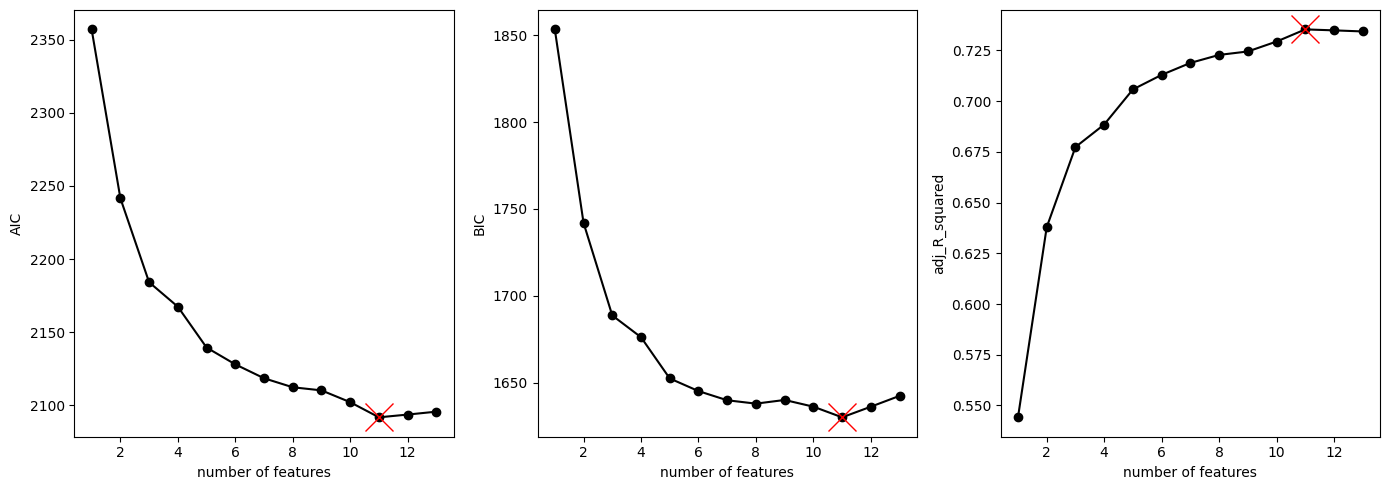

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(14,5))
vars = ['AIC','BIC','adj_R_squared']
for i,v in enumerate(vars):
    ax[i].plot(result['num_features'], result[v], color='black', marker='o')
    ax[i].set_xlabel('number of features')
    ax[i].set_ylabel(v)
    if v == 'adj_R_squared':
        ax[i].plot(result[v].idxmax(), result[v].max(), marker='x',markersize=20,color='red')
    else:
        ax[i].plot(result[v].idxmin(), result[v].min(), marker='x',markersize=20,color='red')
plt.tight_layout()

 벌점 통계량에 의한 기법으로 11개의 변수가 선택됨

In [ ]:
%load_ext rpy2.ipython

%R -i df
%R class(df)

'data.frame'


In [ ]:
%%R
step(lm(medv~1, data=df), scope=list(lower=~1,upper=~crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+b+lstat), direction='forward')

Start:  AIC=2246.51
medv ~ 1

          Df Sum of Sq   RSS    AIC
+ lstat    1   23243.9 19472 1851.0
+ rm       1   20654.4 22062 1914.2
+ ptratio  1   11014.3 31702 2097.6
+ indus    1    9995.2 32721 2113.6
+ tax      1    9377.3 33339 2123.1
+ nox      1    7800.1 34916 2146.5
+ crim     1    6440.8 36276 2165.8
+ rad      1    6221.1 36495 2168.9
+ age      1    6069.8 36647 2171.0
+ zn       1    5549.7 37167 2178.1
+ b        1    4749.9 37966 2188.9
+ dis      1    2668.2 40048 2215.9
+ chas     1    1312.1 41404 2232.7
<none>                 42716 2246.5

Step:  AIC=1851.01
medv ~ lstat

          Df Sum of Sq   RSS    AIC
+ rm       1    4033.1 15439 1735.6
+ ptratio  1    2670.1 16802 1778.4
+ chas     1     786.3 18686 1832.2
+ dis      1     772.4 18700 1832.5
+ age      1     304.3 19168 1845.0
+ tax      1     274.4 19198 1845.8
+ b        1     198.3 19274 1847.8
+ zn       1     160.3 19312 1848.8
+ crim     1     146.9 19325 1849.2
+ indus    1      98.7 19374 1850.4


In [ ]:
# 교차검증에 의한 선택
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=123)
X = df[xvars]
y = df['medv']

## 결과 행렬 정의
result_list = []

# 각 폴더에 대하여
for i, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    tmp_list = []
    # 각 변수 그룹에 대하여
    for j in np.arange(len(result)):
        vars = result.iloc[j]['features']
        fit = sm.OLS(y_train, sm.add_constant(X_train[vars])).fit()
        RSS = np.sum((y_valid - fit.predict(sm.add_constant(X_valid[vars])))**2)
        R_squared = 1 - RSS/np.sum((y_valid-np.mean(y_valid))**2)
        tmp_list.append(RSS)
    result_list.append(tmp_list)

result_list = np.array(result_list)

# 각 변수별로 잔차제곱합 평균 구하기
rss_mean = np.nanmean(result_list, axis=0)

# 최소값을 주는 변수 목록
min_idx = np.nanargmin(rss_mean)
print(result.iloc[min_idx]['features'])

['lstat', 'rm', 'ptratio', 'dis', 'nox', 'chas', 'b', 'zn', 'crim', 'rad', 'tax']


Text(0, 0.5, 'RSS')

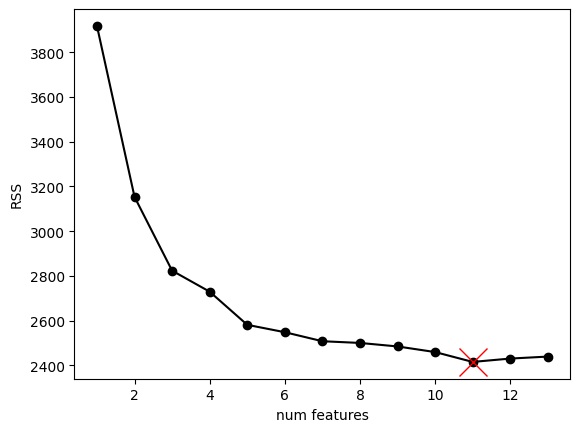

In [ ]:
plt.plot(result['num_features'], rss_mean, marker='o',color='k')
plt.plot(result.iloc[min_idx]['num_features'], rss_mean[min_idx], marker='x',markersize=20, color='red')
plt.xlabel('num features')
plt.ylabel('RSS')

결과를 보면 교차 검증에 의한 변수 선택은 변수의 개수가 11개일 때 선택되었다. 각각의 결과는 항상 일치하지는 않는 경우가 많으므로 이후 추가적인 분석을 통하여 모형, 즉 변수 선택을 확정한다.

### 20.4.2 후진 제거(backward search, backward stepwise elimination)
모든 변수가 들어간 전체 모형에서 변수를 하나씩 제거하며 가장 모형 적합도가 좋은 모형을 선택하는 과정이다.

<img src="https://lh3.google.com/u/0/d/1DAnWz6lSsEKo5eQWEbKi3TCmQ2C3ULyM=w1227-h863-iv1">

In [ ]:
# 데이터 구성
X = df[xvars]
y = df['medv']
k = len(xvars)

# 변수 리스트
remaining_features = list(X.columns.values)

# 사용될 리스트
RSS_list, R_squared_list, features_list = [], [], []

In [ ]:
# 후보 변수 구성 알고리즘
# 변수의 개수별로
for i in np.arange(k,0,-1):
    best_RSS = np.inf

    # 남아 있는 변수 1개씩 추가
    for combi in itertools.combinations(remaining_features,i):
        # 회귀 모형 적합
        testing_features = list(combi)
        fit = sm.OLS(y, sm.add_constant(X[testing_features])).fit()
        RSS = fit.ssr
        R_squared = fit.rsquared
        if RSS < best_RSS:
            best_RSS = RSS
            best_R_squared = R_squared
            best_feature = list(combi)

    # 결과 갱신
    remaining_features = best_feature

    # 결과 저장
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list.append(best_feature)

result = pd.DataFrame()
result['features'] = features_list
result['RSS'] = RSS_list
result['R_squared'] = R_squared_list
display(result)

,features,RSS,R_squared
0,"[age, b, chas, crim, dis, indus, lstat, nox, p...",11078.784578,0.740643
1,"[b, chas, crim, dis, indus, lstat, nox, ptrati...",11078.846412,0.740641
2,"[b, chas, crim, dis, lstat, nox, ptratio, rad,...",11081.363952,0.740582
3,"[b, crim, dis, lstat, nox, ptratio, rad, rm, t...",11308.577606,0.735263
4,"[b, crim, dis, lstat, nox, ptratio, rad, rm, tax]",11565.251292,0.729254
5,"[b, crim, dis, lstat, nox, ptratio, rad, rm]",11790.697104,0.723977
6,"[b, dis, lstat, nox, ptratio, rad, rm]",12014.402991,0.718740
7,"[b, dis, lstat, nox, ptratio, rm]",12157.509921,0.715389
8,"[dis, lstat, nox, ptratio, rm]",12469.344151,0.708089
9,"[dis, lstat, ptratio, rm]",13228.907703,0.690308


In [ ]:
# 적합 통계량(AIC, BIC, R-square adjusted) 계산
result['num_features'] = result['features'].map(len)

# p = len(xvars)+1
p = result['num_features']
n = len(y)

result['AIC'] = n*np.log(result['RSS']/n) + 2*p + n + 2
result['BIC'] = n*np.log(result['RSS']/n) + p*np.log(n)
result['adj_R_squared'] = 1-(n-1)*(1-result['R_squared'])/(n-p)
result

,features,RSS,R_squared,num_features,AIC,BIC,adj_R_squared
0,"[age, b, chas, crim, dis, indus, lstat, nox, p...",11078.784578,0.740643,13,2095.642798,1642.587775,0.734330
1,"[b, chas, crim, dis, indus, lstat, nox, ptrati...",11078.846412,0.740641,12,2093.645623,1636.364063,0.734866
2,"[b, chas, crim, dis, lstat, nox, ptratio, rad,...",11081.363952,0.740582,11,2091.760592,1630.252496,0.735342
3,"[b, crim, dis, lstat, nox, ptratio, rad, rm, t...",11308.577606,0.735263,10,2100.030745,1634.296111,0.730459
4,"[b, crim, dis, lstat, nox, ptratio, rad, rm, tax]",11565.251292,0.729254,9,2109.387159,1639.425989,0.724896
5,"[b, crim, dis, lstat, nox, ptratio, rad, rm]",11790.697104,0.723977,8,2117.155901,1642.968195,0.720097
6,"[b, dis, lstat, nox, ptratio, rad, rm]",12014.402991,0.718740,7,2124.666343,1646.252100,0.715358
7,"[b, dis, lstat, nox, ptratio, rm]",12157.509921,0.715389,6,2128.657839,1646.017059,0.712543
8,"[dis, lstat, nox, ptratio, rm]",12469.344151,0.708089,5,2139.472838,1652.605521,0.705759
9,"[dis, lstat, ptratio, rm]",13228.907703,0.690308,4,2167.393249,1676.299396,0.688457


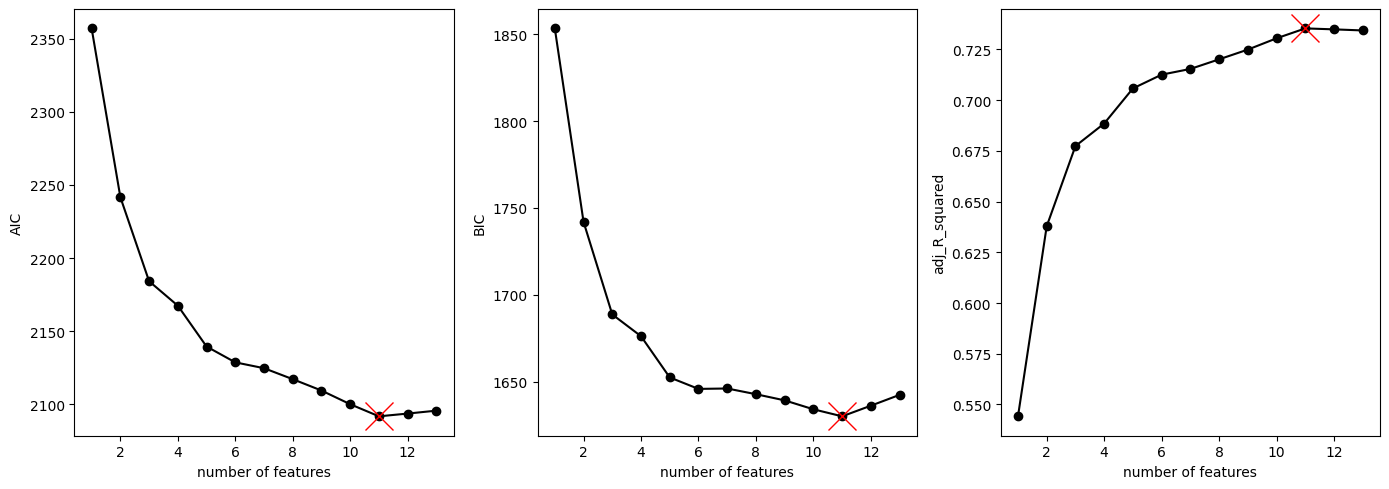

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(14,5))
vars = ['AIC','BIC','adj_R_squared']
for i,v in enumerate(vars):
    ax[i].plot(result['num_features'], result[v], color='black', marker='o')
    ax[i].set_xlabel('number of features')
    ax[i].set_ylabel(v)
    if v == 'adj_R_squared':
        ax[i].plot(result.iloc[result[v].idxmax()]['num_features'], result[v].max(), marker='x',markersize=20,color='red')
    else:
        ax[i].plot(result.iloc[result[v].idxmin()]['num_features'], result[v].min(), marker='x',markersize=20,color='red')
plt.tight_layout()

In [ ]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=123)
X = df[xvars]
y = df['medv']

## 결과 행렬 정의
result_list = []

# 각 폴더에 대하여
for i, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    tmp_list = []
    # 각 변수 그룹에 대하여
    for j in np.arange(len(result)):
        vars = result.iloc[j]['features']
        fit = sm.OLS(y_train, sm.add_constant(X_train[vars])).fit()
        RSS = np.sum((y_valid - fit.predict(sm.add_constant(X_valid[vars])))**2)
        R_squared = 1 - RSS/np.sum((y_valid-np.mean(y_valid))**2)
        tmp_list.append(RSS)
    result_list.append(tmp_list)

result_list = np.array(result_list)

# 각 변수별로 잔차제곱합 평균 구하기
rss_mean = np.nanmean(result_list, axis=0)

# 최소값을 주는 변수 목록
min_idx = np.nanargmin(rss_mean)
print(result.iloc[min_idx]['features'])

['b', 'chas', 'crim', 'dis', 'lstat', 'nox', 'ptratio', 'rad', 'rm', 'tax', 'zn']


Text(0, 0.5, 'RSS')

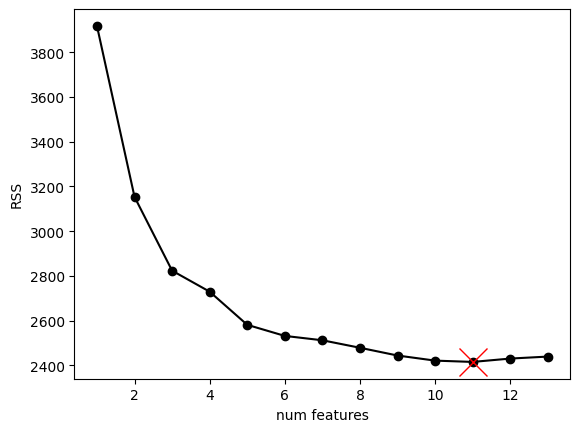

In [ ]:
plt.plot(result['num_features'], rss_mean, marker='o',color='k')
plt.plot(result.iloc[min_idx]['num_features'], rss_mean[min_idx], marker='x',markersize=20, color='red')
plt.xlabel('num features')
plt.ylabel('RSS')

교차 검증에 의한 변수 선택에서는 그림과 같이 11개의 변수가 선택되었다.

### 20.4.3 혼성 방법
혼성(hybrid) 방법은 전진 선택 방법과 후진 제거 방법을 섞은 방법이다. 기본 구조는 전진 선택이지만 단계마다 후진 제거 방식에 의한 변수 제거를 하는 것이다. 예를 들어, 전진 선택에 의해 한 번에 하나의 변수가 추가되고, 들어온 변수들에 대하여 후진제거 방식에 의해 제거할 변수가 있으면 제거하는 것이다. 이러한 과정을 순차 대체(seuquential replacement)라고 한다.

### 20.4.4 요약
전진 선택 및 후진 제거에 의한 후보 변수를 구성한 후 교차 검증 방법에 의하여 제거된 변수는 'age','indus'이다. 이 변수들의 종속 변수에 대한 유의미 여부는 간단히 산점도 행렬로 확인한다.

In [ ]:
del_vars = list(set(xvars) - set(result.iloc[min_idx]['features']))
del_vars

['age', 'indus']

<Figure size 600x600 with 0 Axes>

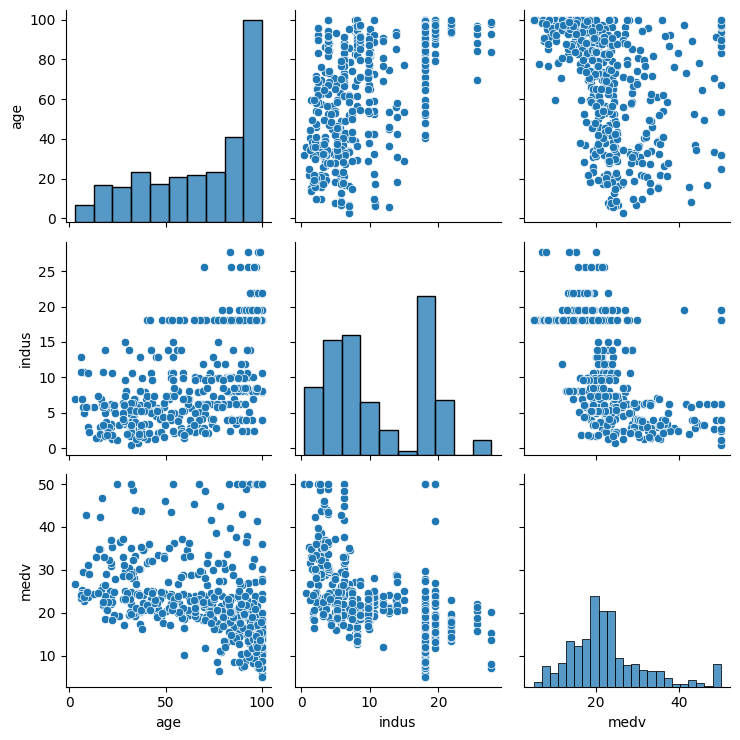

In [ ]:
plt.figure(figsize=(6,6))
sns.pairplot(df[del_vars + ['medv']])
plt.tight_layout()
plt.show()

결과를 보면 종속변수에 대해 특별한 유형이 있다고 볼 수 없다.

## 20.5 능형(rigde)과 라쏘(lasso) 회귀

단계적 모형 선택 방법은 선형회귀 모형을 적합하고 난 후 추가적인 과정을 거쳐서 모형을 선택하는 방법이다.

이에 반해 ridge회귀와 lasso회귀처럼 모형을 적합하는 과정에서 변수가 자동적으로 선택되게끔하는 방법 역시 있다.

ridge와 lasso에 적합시키기 위해서는 반드시 모든 변수에 대해 표준화가 되어있어야한다.

$({x_i - \bar{x}}) / {\sqrt{{\Sigma_i (x_i-\bar{x})^2} \over {n-1}}}$

In [ ]:
from sklearn.linear_model import Ridge,Lasso

In [ ]:
# 능형 회귀, 라쏘 회귀 적합을 위한 데이터 전처리
target_var = 'medv'
input_vars = list(df.columns)
input_vars.remove(target_var)

# 표준화
sdf = (df-np.mean(df,axis=0))/np.std(df, ddof=1, axis=0)

# X,y split
X = sdf[input_vars].values
y = sdf[target_var].values

### 20.5.1 능형 회귀(ridge regression)

선형회귀모형에서 사용되는 손실함수에 다음과 같은 축소 벌점(shrinkage penalty)이 추가된 경우이다. 다음과 같은 벌점을 L2 정규화라고 한다.

$$
\begin{align*}
J(\beta) \\
&= Σ_{i=1}^n (y_i - \beta_0 - \Sigma_{j=1}^p \beta_j x_{ij})^2 + \lambdaΣ_{j=1}^p  \beta_j^2 \\
&= RSS + \lambdaΣ_{j=1}^p  \beta_j^2
\end{align*}
$$

여기서 $\lambda \ge 0$는 tuning parameter이다.

축소 벌점(shrinkage penalty)는 각 $\beta_j$들이 0에 가까워진다는 의미이며 이는 0으로 축소되는 효과를 의미한다. 회귀계수가 0에 가깝다는 의미는 해당 모수의 변수가 유의하지 않다는 의미이다.

손실함수를 최소화하기 위해 $\lambda$가 0이면 일반 선형회귀 모형이 되며, 무한대에 가까운 큰 값이면 $Σ_{j=1}^p  \beta_j^2$은 0에 가까워야 하고 따라서 모든 회귀계수 값은 0에 매우 가까운 값이 된다.

완전모형(full model)을 적합하면 비용함수의 RSS는 작아지지만 반대로 모수가 많기 때문에 축소벌점이 커진다.

In [ ]:
# 추정해야 할 모수 (절편 제외)
nparams = len(input_vars)

# 람다 값의 범위
lambdas = np.logspace(-7,12,100,base=np.exp(1))

# 모수 값을 넣기 위한 행렬 생성: 하나의 열이 동일한 람다 값
coef = np.zeros(shape=(nparams, len(lambdas)))

# 평균제곱오차 값을 넣기 위한 벡터
costs = np.zeros_like(lambdas, float)

# 교차 검증에 의한 평균제곱오차 계산
num_folders = 5
for i, l in enumerate(lambdas):
    ridge = Ridge(alpha=l, fit_intercept=False)
    ridge.fit(X,y)
    coef[:,i] = ridge.coef_

    # 각 람다 값에 따른 교차 검증에 의한 평균 제곱오차의 계산
    fold_costs = []
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=123)
    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        # 각 폴더에 대한 모형 적합
        ridge = Ridge(alpha=l, fit_intercept=False)
        ridge.fit(X_train, y_train)

        # 평균제곱오차 계산
        pred = ridge.predict(X_valid)
        cost = np.sum((pred-y_valid)**2) / len(y_valid)
        fold_costs.append(cost)
    # 평균제곱오차 평균계산
    costs[i] = np.mean(fold_costs)

# 평균제곱오차를 최소화하는 람다
min_index = np.argmin(costs)
lambdas[min_index]

7.539847981425933

In [ ]:
# 최소값을 줄 때의 표준화된 회귀계수 값들
res = pd.DataFrame()
res['Variable'] = input_vars
res['Coefficient'] = coef[:,min_index]
res.round(3)

,Variable,Coefficient
0,crim,-0.095
1,zn,0.107
2,indus,-0.001
3,chas,0.076
4,nox,-0.203
5,rm,0.297
6,age,-0.002
7,dis,-0.317
8,rad,0.241
9,tax,-0.181


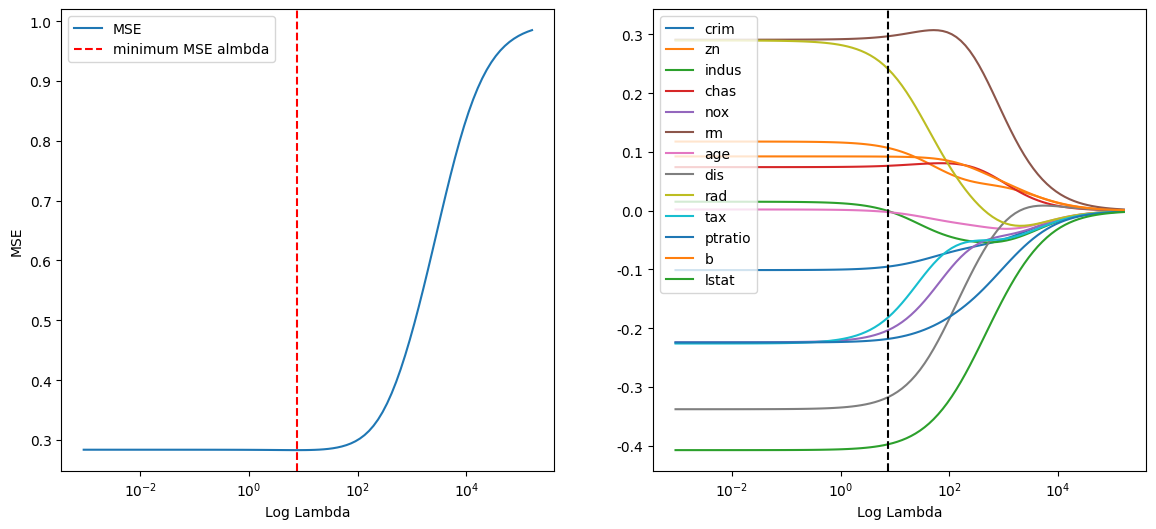

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(lambdas, costs)
plt.xscale('log')
plt.axvline(lambdas[min_index], linestyle='--', color='r')
plt.xlabel('Log Lambda')
plt.ylabel('MSE')
plt.legend(['MSE','minimum MSE almbda'])

plt.subplot(1,2,2)
for i in range(coef.shape[0]):
    plt.plot(lambdas, coef[i,:],label=input_vars[i])
plt.xscale('log')
plt.xlabel('Log Lambda')
plt.legend()
plt.axvline(lambdas[min_index], linestyle='--', color='k')

plt.show()

### 20.5.2 라쏘 회귀
ridge에서는 계수의 제곱합에 벌점을 주었으나 LASSO(least absolute shrinkage and selection operator) 회귀는 절대값에 벌점을 주는 L1 정규화를 취한다. 다음은 LASSO의 손실함수이다.

$$
\begin{align*}
J(\beta) \\
&= Σ_{i=1}^n (y_i - \beta_0 - \Sigma_{j=1}^p \beta_j x_{ij})^2 + \lambdaΣ_{j=1}^p  |\beta_j| \\
&= RSS + \lambdaΣ_{j=1}^p  |\beta_j|
\end{align*}
$$

lasso의 영문명을 보면 선택 연산자(selection operator)라는 이름을 갖고 있다. 즉 자동으로 변수를 선택한다는 것이다. ridge에서는 회귀계수가 0에 가깝지만 0은 아니어서 해당 변수의 선택 여부를 판단하기가 어려웠다.

<img src="https://lh3.google.com/u/0/d/1nH56z16L7km05nvHQZIyDMMa2zqO_2RI=w1227-h863-iv1">

In [ ]:
# 추정해야 할 모수 (절편 제외)
nparams = len(input_vars)

# 람다 값의 범위
lambdas = np.logspace(-10,5,100,base=np.exp(1))

# 모수 값을 넣기 위한 행렬 생성: 하나의 열이 동일한 람다 값
coef = np.zeros(shape=(nparams, len(lambdas)))

# 평균제곱오차 값을 넣기 위한 벡터
costs = np.zeros_like(lambdas, float)

# 교차 검증에 의한 평균제곱오차 계산
num_folders = 5
for i, l in enumerate(lambdas):
    lasso = Lasso(alpha=l, fit_intercept=False)
    lasso.fit(X,y)
    coef[:,i] = lasso.coef_

    # 각 람다 값에 따른 교차 검증에 의한 평균 제곱오차의 계산
    fold_costs = []
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=123)
    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        # 각 폴더에 대한 모형 적합
        lasso = Lasso(alpha=l, fit_intercept=False)
        lasso.fit(X_train, y_train)

        # 평균제곱오차 계산
        pred = lasso.predict(X_valid)
        cost = np.sum((pred-y_valid)**2) / len(y_valid)
        fold_costs.append(cost)
    # 평균제곱오차 평균계산
    costs[i] = np.mean(fold_costs)

# 평균제곱오차를 최소화하는 람다
min_index = np.argmin(costs)

In [ ]:
# 최소값을 줄 때의 표준화된 회귀계수 값들
res = pd.DataFrame()
res['Variable'] = input_vars
res['Coefficient'] = coef[:,min_index]
res.round(3)

,Variable,Coefficient
0,crim,-0.094
1,zn,0.108
2,indus,0.000
3,chas,0.074
4,nox,-0.209
5,rm,0.294
6,age,-0.000
7,dis,-0.325
8,rad,0.251
9,tax,-0.189


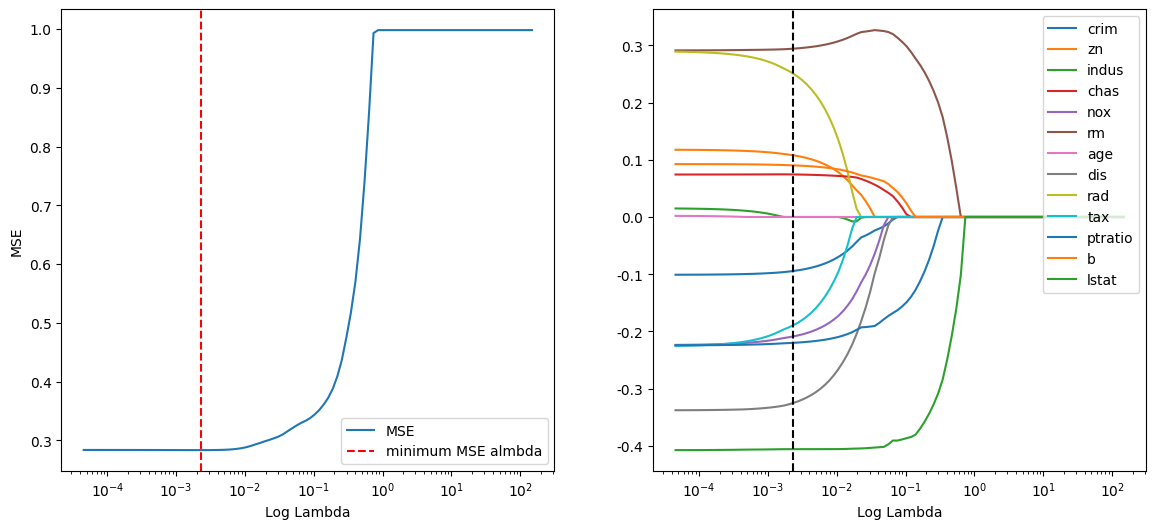

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(lambdas, costs)
plt.xscale('log')
plt.axvline(lambdas[min_index], linestyle='--', color='r')
plt.xlabel('Log Lambda')
plt.ylabel('MSE')
plt.legend(['MSE','minimum MSE almbda'])

plt.subplot(1,2,2)
for i in range(coef.shape[0]):
    plt.plot(lambdas, coef[i,:],label=input_vars[i])
plt.xscale('log')
plt.xlabel('Log Lambda')
plt.legend(loc='upper right')
plt.axvline(lambdas[min_index], linestyle='--', color='k')

plt.show()